# TAYLOR SWIFT MUSIC ALBUM ANALYSIS

## Abhrajit Das
## U01880578

In [1]:
%matplotlib inline

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

# 1. load dataset

In [2]:
lyrics = pd.read_csv("taylor_swift_lyrics_2006-2022_all.csv")

#Inspected the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5


# 2. Got info about the DataFrame

In [3]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9370 entries, 0 to 9369
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   9370 non-null   object
 1   track_title  9370 non-null   object
 2   track_n      9370 non-null   int64 
 3   lyric        9370 non-null   object
 4   line         9370 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 366.1+ KB


### No Missing Values

In [4]:
# 2. Got a list of all the albums in this collection
print(lyrics.album_name.unique())

['Fearless (Taylor’s Version)' 'Red (Deluxe Edition)' '1989 (Deluxe)'
 'midnights' 'midnights (3am edition)' 'reputation' 'Taylor Swift'
 'folklore (deluxe version)' 'Lover' 'evermore (deluxe version)'
 'Speak Now (Deluxe)']


### We see that the release years are not mentioned. 
### So we can manually add them or merge any other csv that contained the years.

In [5]:
#This is a function to map the name of the album to the year it was released
#Here we did some research and manually added the year an album was released

def album_release(row):  
    if row['album_name'] == 'Taylor Swift':
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021'
    
    return 'No Date'

#Applied the function to the album
lyrics['album_year'] = lyrics.apply(lambda row: album_release(row), axis=1)

#Inspected the first few rows of the DataFrame
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008


# 3. Cleaned the lyric text


In [6]:
#To accurately count keyword mentions, we need to:
#lowercase everything,
#remove punctuation,
#and exclude stop words.

#Saved this in a new column called clean_lyric

#lowercase
lyrics['clean_lyric'] = lyrics['lyric'].str.lower()

#remove punctuation
lyrics['clean_lyric']= lyrics['clean_lyric'].str.replace('[^\w\s]','')
lyrics.head()

#remove stopwords (see the next cell for illustration)
#create a small list of English stop words, feel free to edit this list
stop = ['the', 'a', 'this', 'that', 'to', 'is', 'am', 'was', 'were', 'be', 'being', 'been']

#we make a list of words with `.split()`
#then we remove all the words in our list
#then we join the words back together into a string
lyrics['clean_lyric'] = lyrics['clean_lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car"
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah"


In [7]:
#The next cells are for illustration only to see:

#what `.split()` does
lyrics['clean_lyric_list'] = lyrics['clean_lyric'].apply(lambda x: x.split())
print(lyrics.head())

#what `.join()` does
lyrics['clean_lyric_list_rejoined'] = lyrics['clean_lyric_list'].apply(lambda x: ' '.join(x))
print(lyrics.head())

#To remove those illustration columns
lyrics.drop(['clean_lyric_list', 'clean_lyric_list_rejoined'], axis=1, inplace=True)
print(lyrics.head())

#there are many pre-built lists of stopwords, including one from sklearn.
from sklearn.feature_extraction import text
skl_stop = text.ENGLISH_STOP_WORDS
print(skl_stop)

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  \
0                     there's something 'bout way   
1              street 

# 4.  how many times midnight occurs in Taylor Swift's lyrics?

In [51]:
#Because we are most interested in "midnight", 
#We will first count how many times midnight occurs in Taylor Swift's lyrics.

#Created a new column to indicate if a lyric has "midnight" in it.
#We checked how many times midnight occurrs

#create a new column to reflect if the lyrics contain midnight
lyrics['midnight'] = lyrics['clean_lyric'].str.contains('midnight')
sum(lyrics['midnight'])

20

### Midnight is not very common -- it only appeared 20 times!

# 5. Expanded the keyword list

In [9]:
#Midnight might not be the only way that Taylor Swift has talked about night.
#We need to expand our list.
#We've made a list of night words and day words.

#Created two new columns, one for night words, and one for day words
#Joined the lists into a regular expression string using the .join() function and the | to indicate "or"
#Checked the clean lyrics for the presence of words in the regular expression we just made.
#Counted how many times the words appeared and print them to the screen
#Inspected the first few rows of the lyrics DataFrame to be sure it looks as you expect


#night, day, and other time-related words
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright']
time = ['today', 'tomorrow', 'yesterday']

#create a regular expression string for each list of words
night_regex = '|'.join(night)
day_regex = '|'.join(day)
time_regex = '|'.join(time)

#create a new column for each category of words
lyrics['night'] = lyrics['clean_lyric'].str.contains(night_regex)
lyrics['day'] = lyrics['clean_lyric'].str.contains(day_regex)
lyrics['time'] = lyrics['clean_lyric'].str.contains(time_regex)

#count the number of times each category of word appears in the lyrics
night_count = sum(lyrics['night'])
day_count = sum(lyrics['day'])
time_count = sum(lyrics['time'])

#print the count of each word category
print("night words: ", night_count)
print("day words: ", day_count)
print("time words: ", time_count)

#inspect the first few rows
lyrics.head()

night words:  287
day words:  387
time words:  35


,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,False
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,False
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,False
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,False


### Taylor Swift has referenced time alot, there's enough mentions for us to potentially spot some trends. Also, she has mentioned day far more than night. This might be because of the search terms, so we might consider revisiting the list. Or it could be because she is actually more focused on day and light than she is on night and dark.

# 6. Visualize how Taylor Swift's mentions of time have changed over time.

In [10]:
#Now that we know that she has referenced time, we can see if that has changed, 
#and if she has been dropping any hints about her upcoming album.

#Created a new dataframe called yearly_mentions that groups her mentions by year, 
#and takes the sum of the other columns. Reset the index on this DataFrame to make it easier to use with matplotlib
#Created a line chart in matplotlib showing the night mentions over time.

#created a new dataframe for yearly mentions that groups mentions by year
yearly_mentions = lyrics.groupby('album_year').sum().reset_index()
yearly_mentions

,album_year,album_name,track_title,track_n,lyric,line,clean_lyric,midnight,night,day,time
0,2006,Taylor SwiftTaylor SwiftTaylor SwiftTaylor Swi...,Tim McGrawTim McGrawTim McGrawTim McGrawTim Mc...,4867,He said the way my blue eyes shinedPut those G...,13456,he said way my blue eyes shinedput those georg...,0,19,25,3
1,2008,Fearless (Taylor’s Version)Fearless (Taylor’s ...,Fearless (Taylor’s Version)Fearless (Taylor’s ...,15644,There's something 'bout the wayThe street look...,27793,there's something 'bout waystreet looks when i...,0,42,65,20
2,2010,Speak Now (Deluxe)Speak Now (Deluxe)Speak Now ...,MineMineMineMineMineMineMineMineMineMineMineMi...,8450,"You were in college, working part-time, waitin...",27489,"you in college, working part-time, waiting tab...",0,31,53,4
3,2012,Red (Deluxe Edition)Red (Deluxe Edition)Red (D...,State of GraceState of GraceState of GraceStat...,11992,I'm walking fast through the traffic lightsBus...,27800,i'm walking fast through traffic lightsbusy st...,1,48,53,7
4,2014,1989 (Deluxe)1989 (Deluxe)1989 (Deluxe)1989 (D...,Welcome to New YorkWelcome to New YorkWelcome ...,8424,"Walking through a crowd, the village is aglowK...",33546,"walking through crowd, village aglowkaleidosco...",2,27,41,0
5,2017,reputationreputationreputationreputationreputa...,...Ready for It?...Ready for It?...Ready for I...,7640,Knew he was a killer first time that I saw him...,33775,knew he killer first time i saw himwondered ho...,3,25,25,0
6,2019,LoverLoverLoverLoverLoverLoverLoverLoverLoverL...,I Forgot That You ExistedI Forgot That You Exi...,8813,How many days did I spend thinking'Bout how yo...,25741,how many days did i spend thinking'bout how yo...,0,22,46,0
7,2020,evermore (deluxe version)evermore (deluxe vers...,willowwillowwillowwillowwillowwillowwillowwill...,8443,I'm like the water when your ship rolled in th...,25712,i'm like water when your ship rolled in nightr...,2,18,38,0
8,2021,folklore (deluxe version)folklore (deluxe vers...,the 1the 1the 1the 1the 1the 1the 1the 1the 1t...,6193,"I'm doing good, I'm on some new shitBeen sayin...",16854,"i'm doing good, i'm on some new shitsaying ""ye...",1,8,17,1
9,No Date,midnightsmidnightsmidnightsmidnightsmidnightsm...,lavendar hazelavendar hazelavendar hazelavenda...,10553,Meet me at midnightStaring at the ceiling with...,27345,meet me at midnightstaring at ceiling with you...,11,47,24,0


# 7. What albums are the most night/day focused?

In [11]:
#Now that we have a table of counts, it's very easy to figure out which albums have the most mentions of day or night.
#But our DataFrame only has the years, not the album names. We need to add those back in.
#Ran the code that reinstates the album name for this dataframe.
#Use .sort_values() to order the yearly_mentions table and find which year has the most mentions of night.
#Did the same for the day column.

#reinstate the album name
#read the album_year_name.csv
year_name = pd.read_csv('album_year_name.csv')

#sort both dataframes by year
yearly_mentions.sort_values(by='album_year', ascending=True, inplace=True)
year_name.sort_values(by='album_year', ascending=True, inplace=True)

#add the new column for album name
yearly_mentions['album_name'] = year_name['album_name']

#sort the lyrics by the night column to find the albums with the most night references
yearly_mentions.sort_values(by='night', ascending=False)

#sort the lyrics by the day column to find the albums with the most day references
yearly_mentions.sort_values(by='day', ascending=False)

,album_year,album_name,track_title,track_n,lyric,line,clean_lyric,midnight,night,day,time
1,2008,Red (Deluxe Edition),Fearless (Taylor’s Version)Fearless (Taylor’s ...,15644,There's something 'bout the wayThe street look...,27793,there's something 'bout waystreet looks when i...,0,42,65,20
2,2010,1989 (Deluxe),MineMineMineMineMineMineMineMineMineMineMineMi...,8450,"You were in college, working part-time, waitin...",27489,"you in college, working part-time, waiting tab...",0,31,53,4
3,2012,reputation,State of GraceState of GraceState of GraceStat...,11992,I'm walking fast through the traffic lightsBus...,27800,i'm walking fast through traffic lightsbusy st...,1,48,53,7
6,2019,Lover,I Forgot That You ExistedI Forgot That You Exi...,8813,How many days did I spend thinking'Bout how yo...,25741,how many days did i spend thinking'bout how yo...,0,22,46,0
4,2014,Taylor Swift,Welcome to New YorkWelcome to New YorkWelcome ...,8424,"Walking through a crowd, the village is aglowK...",33546,"walking through crowd, village aglowkaleidosco...",2,27,41,0
7,2020,evermore (deluxe version),willowwillowwillowwillowwillowwillowwillowwill...,8443,I'm like the water when your ship rolled in th...,25712,i'm like water when your ship rolled in nightr...,2,18,38,0
0,2006,Fearless (Taylor’s Version),Tim McGrawTim McGrawTim McGrawTim McGrawTim Mc...,4867,He said the way my blue eyes shinedPut those G...,13456,he said way my blue eyes shinedput those georg...,0,19,25,3
5,2017,folklore (deluxe version),...Ready for It?...Ready for It?...Ready for I...,7640,Knew he was a killer first time that I saw him...,33775,knew he killer first time i saw himwondered ho...,3,25,25,0
9,No Date,Midnights,lavendar hazelavendar hazelavendar hazelavenda...,10553,Meet me at midnightStaring at the ceiling with...,27345,meet me at midnightstaring at ceiling with you...,11,47,24,0
8,2021,Speak Now (Deluxe),the 1the 1the 1the 1the 1the 1the 1the 1the 1t...,6193,"I'm doing good, I'm on some new shitBeen sayin...",16854,"i'm doing good, i'm on some new shitsaying ""ye...",1,8,17,1


### It seems like her older work focused on day much more than her more recent. There was a period of time (2008-2012) when she was really focused on day, but it seems to have become less central to her work more recently.

# 8. Comparison between day and night mentions

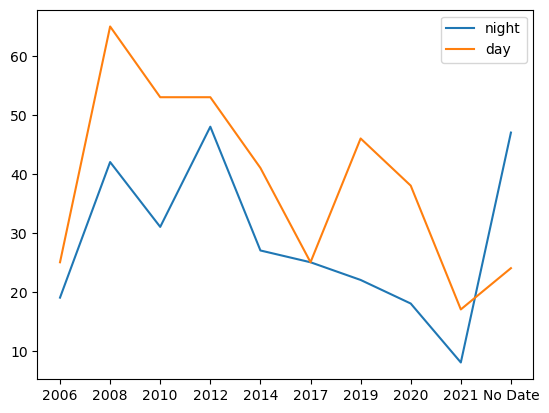

In [12]:
#create a plot with one line showing number of night references by year 
#and another line with the number of day references by year
plt.plot(yearly_mentions['album_year'], yearly_mentions['night'], label = 'night')
plt.plot(yearly_mentions['album_year'], yearly_mentions['day'], label = 'day')
plt.legend()
plt.show()

### We see a similar dip in referencing time around 2017, but a sharp increase in both 2019 and 2020 to reference day

# 9. Investigate position of day vs. night mentions within albums


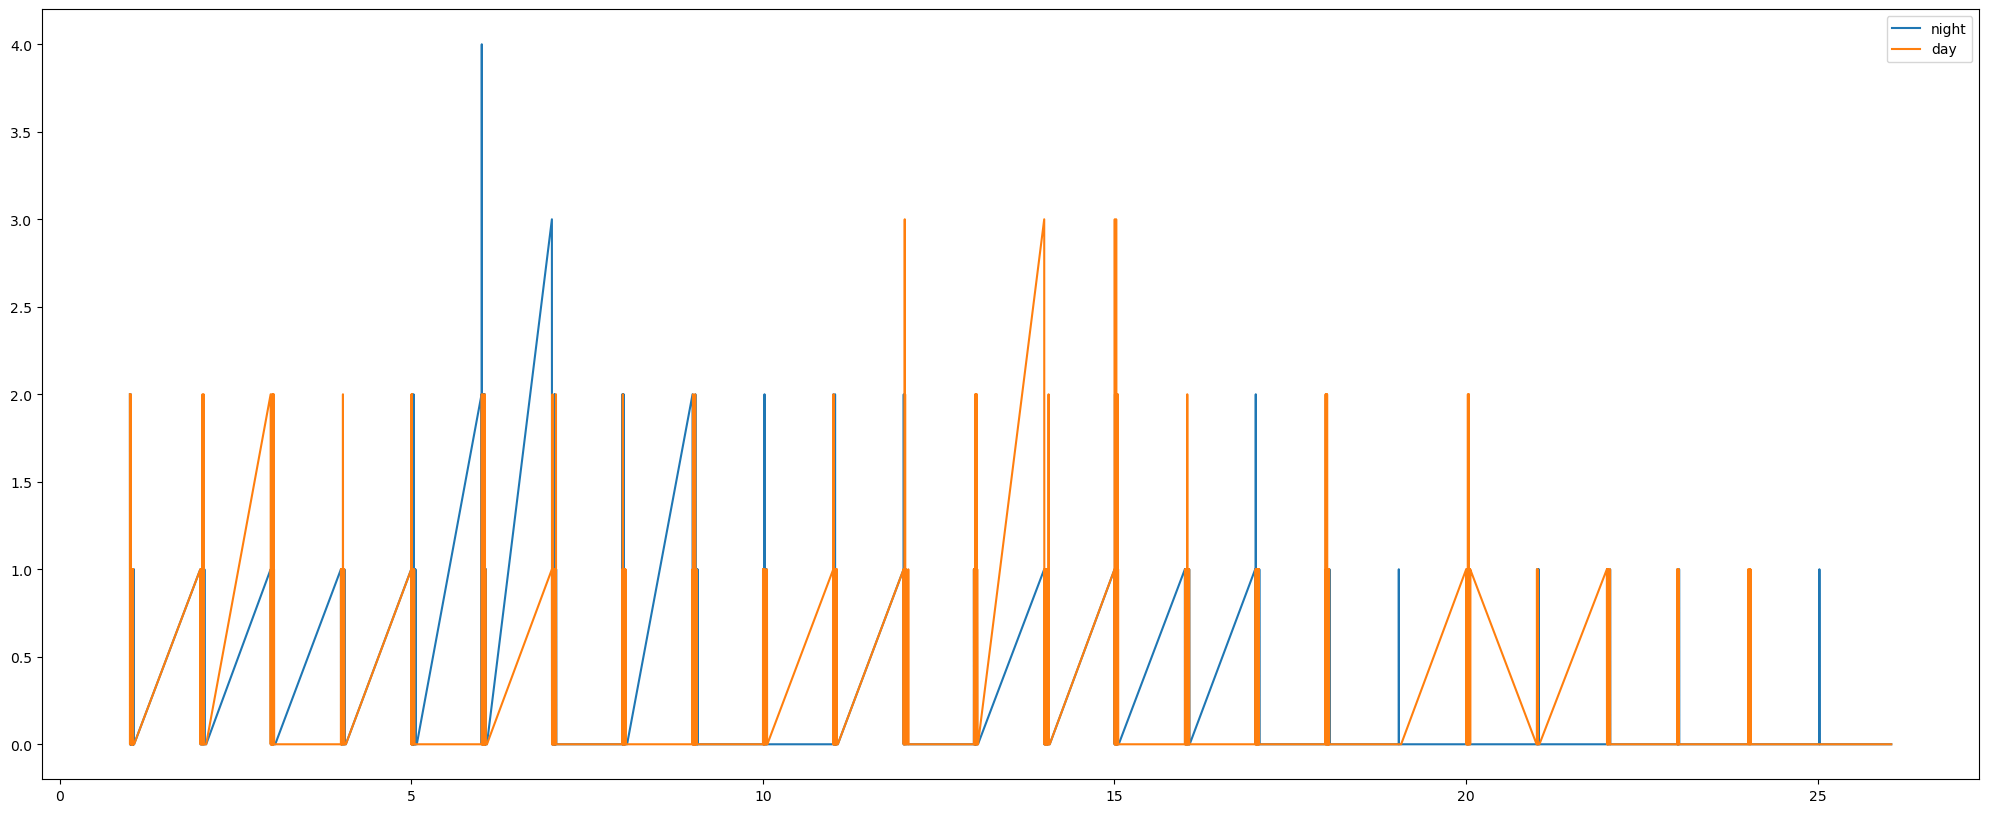

In [13]:
#Created a position variable that includes both the track number and line number
lyrics['position'] = lyrics['track_n'] + (lyrics['line']/1000)

#Create a new DataFrame that is grouped by position
positional_mentions = lyrics.groupby('position').sum().reset_index()

#Increase the size of the plot 
fig = plt.gcf()
fig.set_size_inches(25,10)

#Create a plot with two lines to show frequency of day vs. night references by position in the album
plt.plot(positional_mentions['position'], positional_mentions['night'], label = 'night')
plt.plot(positional_mentions['position'], positional_mentions['day'], label = 'day')
plt.legend()

plt.show()

### Honestly not that much. We can't see any strong trends here.

In [14]:
#Lets run this cell to tokenize the words in the clean_lyric column
lyrics['lyrics_tok'] = lyrics['clean_lyric'].apply(lambda x: word_tokenize(x))

In [15]:
#inspect the first few lines
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,False,1.001,"[there, 's, something, 'bout, way]"
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,False,1.002,"[street, looks, when, it, 's, just, rained]"
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,False,1.003,"[there, 's, glow, off, pavement, ,, you, walk,..."
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wan, na, ask, you, dance, ..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,False,1.005,"[in, middle, of, parking, lot, ,, yeah]"


# 10. Determine what words overall are the most frequently used words

In [16]:
#created a list of all the words in the lyrics_tok column
word_list = [word for list_ in lyrics['lyrics_tok'] for word in list_]

#used the counter function to count the number of times each word appears
word_frequency = collections.Counter(word_list)

#sorted the word frequencies to find out the most common words she's used. 
word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)

#called the word frequency
word_frequency

#She talks mostly about herself. Her lyrics are mostly about her personal life which people can relate

[(',', 4358),
 ('i', 3898),
 ('you', 3582),
 ('and', 1844),
 ('it', 1475),
 ('me', 1146),
 ('in', 1003),
 ("'s", 979),
 ("n't", 947),
 ('my', 927),
 ('(', 725),
 (')', 725),
 ('we', 694),
 ('your', 689),
 ('of', 667),
 ('do', 638),
 ('all', 591),
 ('but', 581),
 ("'m", 563),
 ('like', 552),
 ('on', 539),
 ('?', 511),
 ('know', 477),
 ('so', 454),
 ('oh', 447),
 ("'re", 427),
 ('when', 417),
 ('never', 384),
 ('just', 374),
 ('for', 348),
 ('what', 340),
 ('with', 332),
 ('love', 330),
 ('now', 321),
 ("'ve", 306),
 ('up', 305),
 ("'", 305),
 ('na', 296),
 ('out', 287),
 ('time', 286),
 ("'ll", 285),
 ('if', 276),
 ('at', 276),
 ('back', 276),
 ("'cause", 245),
 ('no', 239),
 ('they', 238),
 ('are', 238),
 ('there', 237),
 ('``', 235),
 ('got', 235),
 ("''", 234),
 ('he', 233),
 ('one', 227),
 ('did', 226),
 ('could', 226),
 ('down', 218),
 ('say', 212),
 ('see', 211),
 ("'d", 207),
 ('think', 202),
 ('would', 198),
 ('baby', 197),
 ('can', 192),
 ('want', 189),
 ('go', 188),
 ('that', 

# 11. Distribution of lyrics across albums (years)

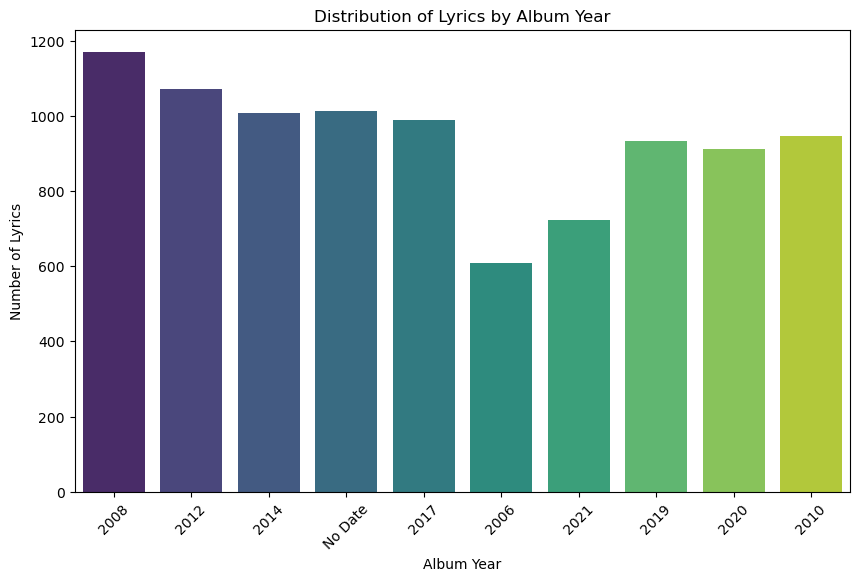

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(x='album_year', data=lyrics, palette='viridis')
plt.title('Distribution of Lyrics by Album Year')
plt.xlabel('Album Year')
plt.ylabel('Number of Lyrics')
plt.xticks(rotation=45)
plt.show()

# 12. Top 20 Most Frequently used words

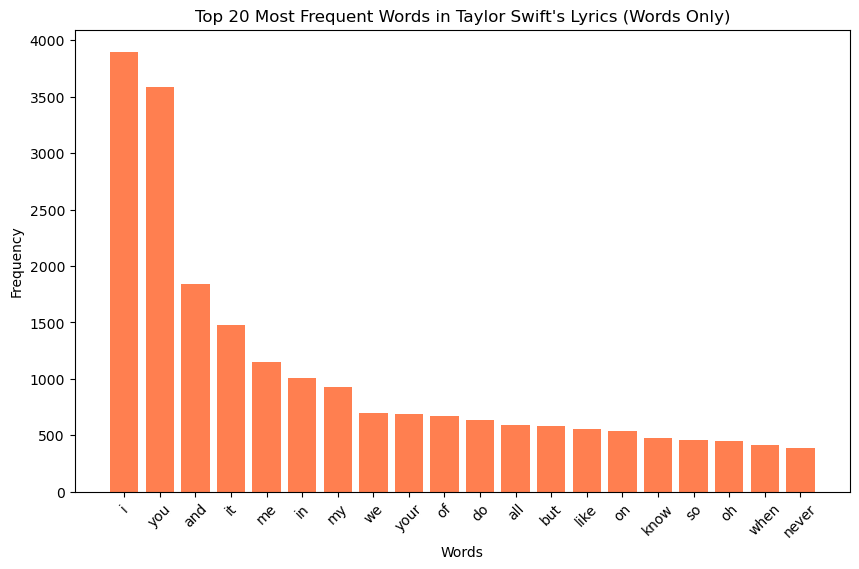

In [18]:
# Create a list of all the words from the tokenized lyrics, filtering only alphabetic words
word_list = [word for list_ in lyrics['lyrics_tok'] for word in list_ if word.isalpha()]

# Use the counter function to count the number of times each word appears
word_frequency = collections.Counter(word_list)

# Sort the word frequencies and get the top 20 most frequent words
word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
top_20_words = dict(word_frequency[:20])

# Plotting the top 20 most frequent words
plt.figure(figsize=(10, 6))
plt.bar(top_20_words.keys(), top_20_words.values(), color='coral')
plt.title('Top 20 Most Frequent Words in Taylor Swift\'s Lyrics (Words Only)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# 13. Combine all cleaned lyrics into one string

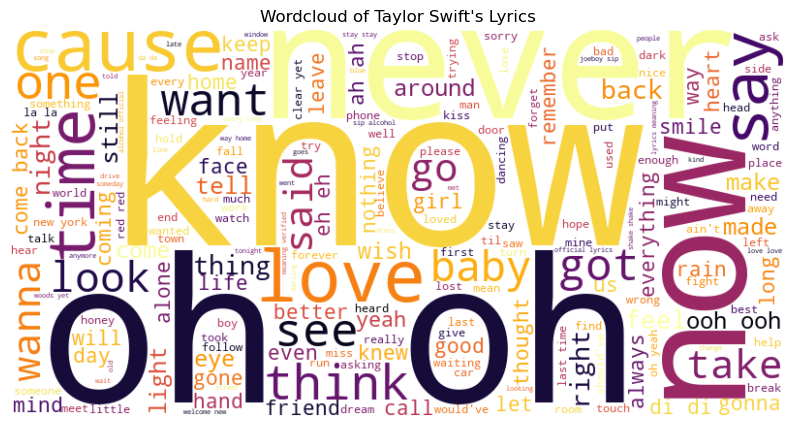

In [19]:
all_lyrics = ' '.join(lyrics['clean_lyric'])

# Generated a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(all_lyrics)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
plt.title('Wordcloud of Taylor Swift\'s Lyrics')
plt.show()

# 14. Boxplot for lyric length across albums

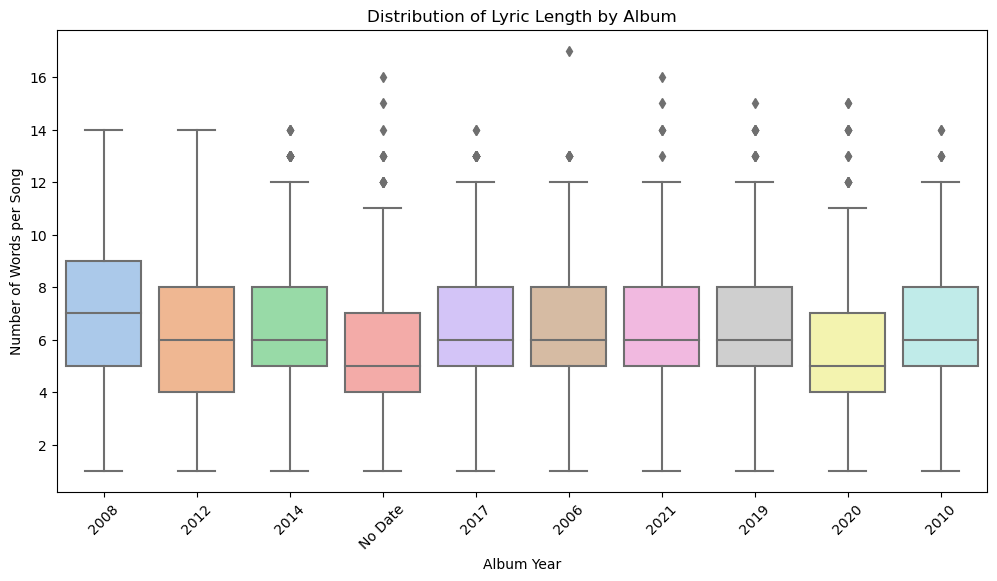

In [20]:
# Create a new column for lyric length
lyrics['lyric_length'] = lyrics['clean_lyric'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.boxplot(x='album_year', y='lyric_length', data=lyrics, palette='pastel')
plt.title('Distribution of Lyric Length by Album')
plt.xlabel('Album Year')
plt.ylabel('Number of Words per Song')
plt.xticks(rotation=45)
plt.show()

# 15. Plot histogram of lyric lengths

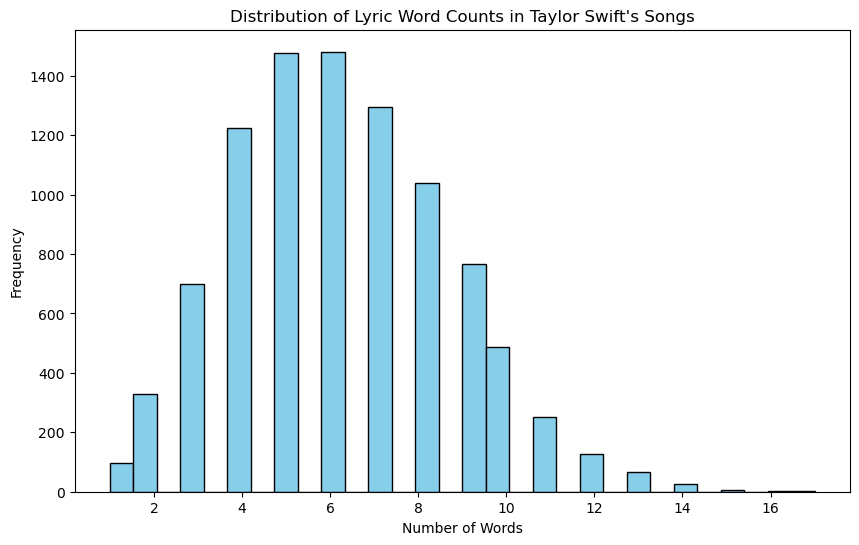

In [21]:
plt.figure(figsize=(10, 6))
plt.hist(lyrics['lyric_length'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Lyric Word Counts in Taylor Swift\'s Songs')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# 16. Mention of the word "Night" throughout the years

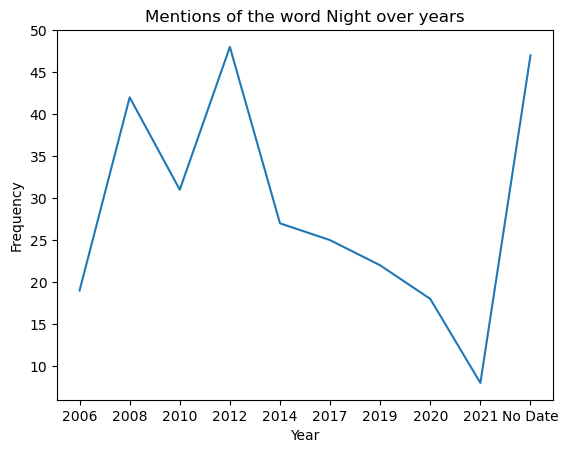

In [22]:
#plot the mentions of night over years
plt.plot(yearly_mentions['album_year'], yearly_mentions['night'])
plt.title('Mentions of the word Night over years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# 17. Average Sentiment Score by Album year

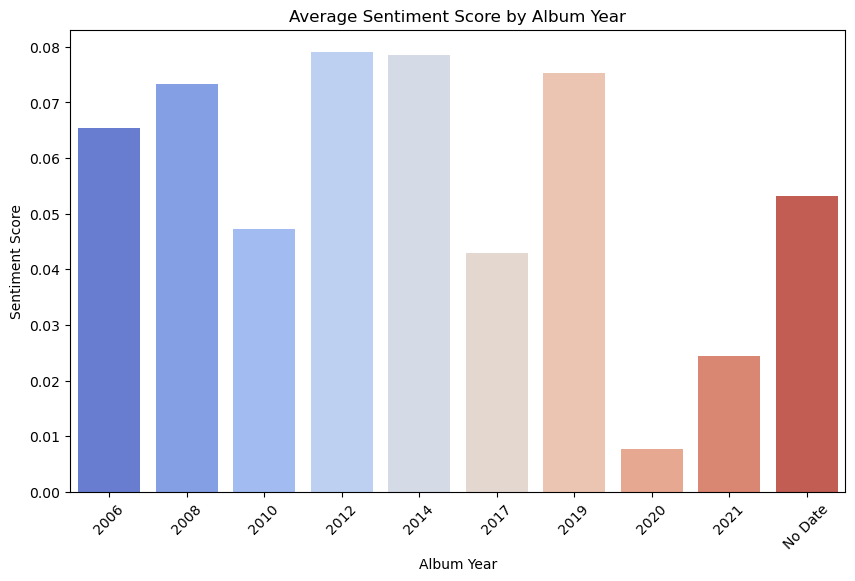

In [23]:
# Initialized the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Applied sentiment analysis on clean lyrics and store sentiment score
lyrics['sentiment'] = lyrics['clean_lyric'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Group by album and calculate mean sentiment score per album
album_sentiment = lyrics.groupby('album_year')['sentiment'].mean().reset_index()

# Plotting the sentiment by album
plt.figure(figsize=(10, 6))
sns.barplot(x='album_year', y='sentiment', data=album_sentiment, palette='coolwarm')
plt.title('Average Sentiment Score by Album Year')
plt.xlabel('Album Year')
plt.ylabel('Sentiment Score')
plt.xticks(rotation=45)
plt.show()

### Positive albums (higher sentiment) are shown with warmer colors.
### Negative albums (lower sentiment) are shown with cooler colors.

# 18. Average Sentiment Across Taylor Swift Albums

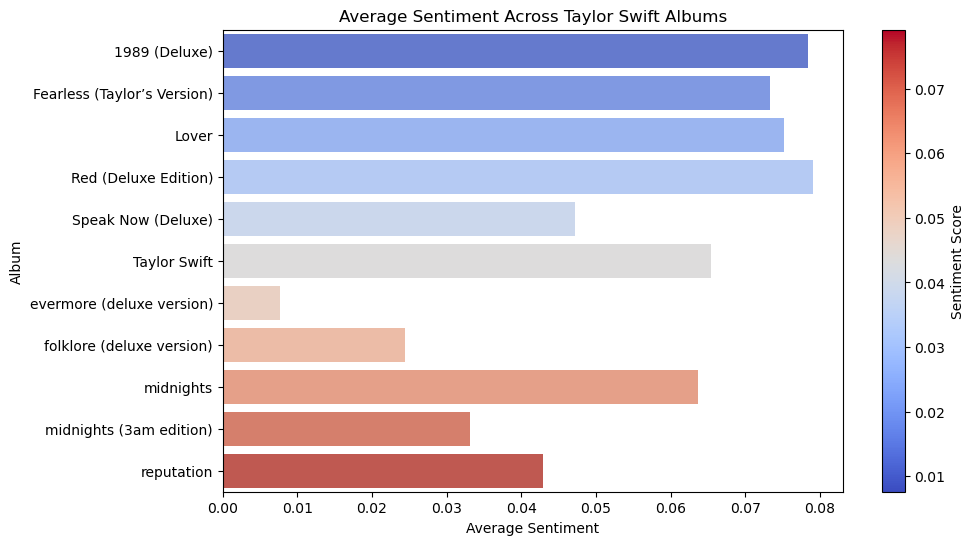

In [24]:
# Grouping by album and calculating the mean sentiment
album_sentiment = lyrics.groupby('album_name')['sentiment'].mean().reset_index()

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Sorting albums by sentiment over time
bar_plot = sns.barplot(x='sentiment', y='album_name', data=album_sentiment, palette='coolwarm', ax=ax)

# Adding color bar with specified axis
norm = plt.Normalize(album_sentiment['sentiment'].min(), album_sentiment['sentiment'].max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Sentiment Score')

# Labels and title
plt.title('Average Sentiment Across Taylor Swift Albums')
plt.xlabel('Average Sentiment')
plt.ylabel('Album')
plt.show()

# 19. Vocabulary Diversity per Album

In [25]:
# Calculate vocabulary diversity for each track (example method)
lyrics['vocab_diversity'] = lyrics['lyric'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)

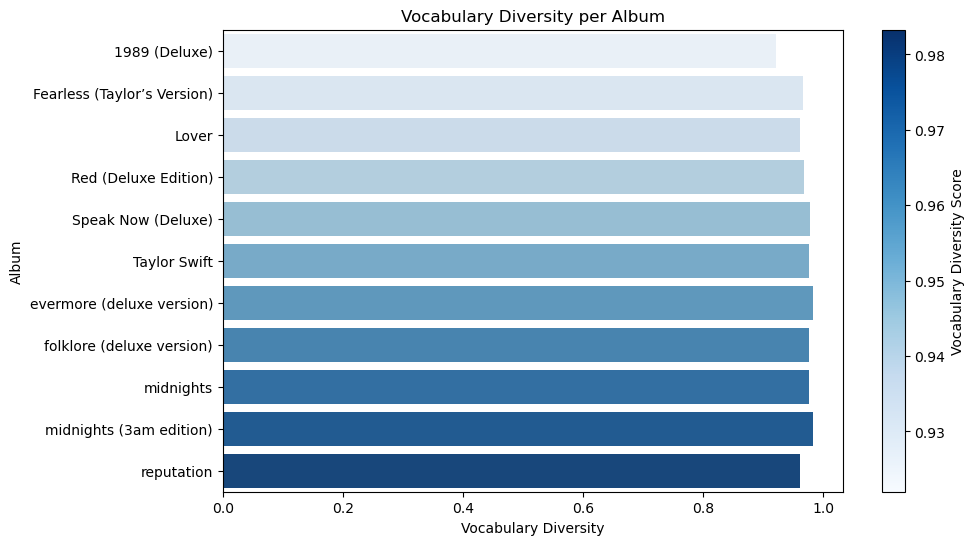

In [26]:
# Calculating average vocabulary diversity for each album
album_vocab_diversity = lyrics.groupby('album_name')['vocab_diversity'].mean().reset_index()

# Create figure and axis objects
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the bar plot
bar_plot = sns.barplot(x='vocab_diversity', y='album_name', data=album_vocab_diversity, palette='Blues', ax=ax)

# Adding color bar with specified axis
norm = plt.Normalize(album_vocab_diversity['vocab_diversity'].min(), album_vocab_diversity['vocab_diversity'].max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label='Vocabulary Diversity Score')

# Plot labels and title
plt.title('Vocabulary Diversity per Album')
plt.xlabel('Vocabulary Diversity')
plt.ylabel('Album')
plt.show()

# 20. Word cloud based on lyrics sentiment

In [27]:
def categorize_sentiment(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

                                      clean_lyric  sentiment  \
0                     there's something 'bout way      0.000   
1              street looks when it's just rained      0.000   
2      there's glow off pavement, you walk me car      0.000   
3  and you know i wanna ask you dance right there      0.000   
4                  in middle of parking lot, yeah      0.296   

  sentiment_category  
0            neutral  
1            neutral  
2            neutral  
3            neutral  
4           positive  


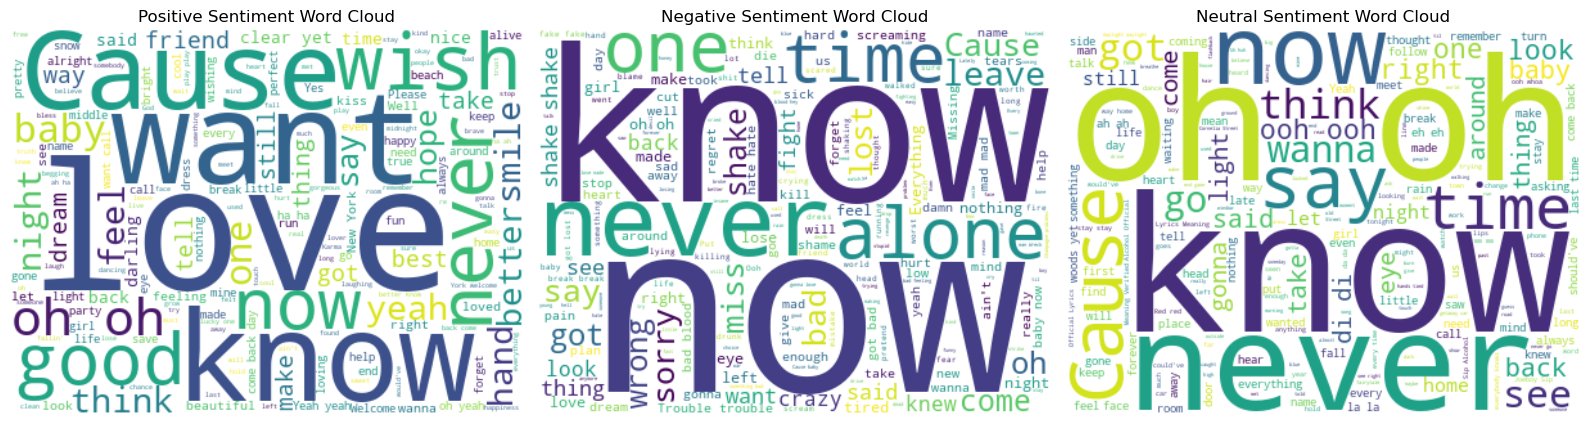

In [28]:
# Applied the function to create a new column for sentiment category
lyrics['sentiment_category'] = lyrics['sentiment'].apply(categorize_sentiment)
#A function categorizes lyrics as positive, negative, or neutral based on compound scores.

# Inspected the updated DataFrame
print(lyrics[['clean_lyric', 'sentiment', 'sentiment_category']].head())# Separate lyrics by sentiment category
positive_lyrics = ' '.join(lyrics[lyrics['sentiment_category'] == 'positive']['lyric'])
negative_lyrics = ' '.join(lyrics[lyrics['sentiment_category'] == 'negative']['lyric'])
neutral_lyrics = ' '.join(lyrics[lyrics['sentiment_category'] == 'neutral']['lyric'])

# Generate word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
wordcloud = WordCloud(width=400, height=300, background_color='white').generate(positive_lyrics)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 2)
wordcloud = WordCloud(width=400, height=300, background_color='white').generate(negative_lyrics)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')

plt.subplot(1, 3, 3)
wordcloud = WordCloud(width=400, height=300, background_color='white').generate(neutral_lyrics)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Neutral Sentiment Word Cloud')
plt.axis('off')

plt.tight_layout()
plt.show()

# 21. How the sentiment analyzer works

In [29]:
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love Taylor Swift!")

#The SentimentIntensityAnalyzer from nltk is initialized to analyze sentiment in each lyric.

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.7424}

In [30]:
# Created a new column called polarity and apply the sia method to the clean_lyric column with a lambda expression
lyrics['polarity'] = lyrics['clean_lyric'].apply(lambda x: sia.polarity_scores(x))
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,lyric_length,sentiment,vocab_diversity,sentiment_category,polarity
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,False,1.001,"[there, 's, something, 'bout, way]",4,0.000,1.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,False,1.002,"[street, looks, when, it, 's, just, rained]",6,0.000,1.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,False,1.003,"[there, 's, glow, off, pavement, ,, you, walk,...",8,0.000,0.916667,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wan, na, ask, you, dance, ...",10,0.000,0.909091,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,False,1.005,"[in, middle, of, parking, lot, ,, yeah]",6,0.296,0.875000,positive,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp..."


### For each lyric in the clean_lyric column, the compound score, a measure of overall sentiment (from -1, very negative, to 1, very positive), is calculated and stored in a new column, sentiment.

In [31]:
# To transform the polarity dictionary into columns of the DataFrame
lyrics[['neg', 'neu', 'pos', 'compound']] = lyrics['polarity'].apply(pd.Series)
lyrics.drop('polarity', axis=1)

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,...,position,lyrics_tok,lyric_length,sentiment,vocab_diversity,sentiment_category,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,...,1.001,"[there, 's, something, 'bout, way]",4,0.000,1.000000,neutral,0.0,1.000,0.000,0.000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,...,1.002,"[street, looks, when, it, 's, just, rained]",6,0.000,1.000000,neutral,0.0,1.000,0.000,0.000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,...,1.003,"[there, 's, glow, off, pavement, ,, you, walk,...",8,0.000,0.916667,neutral,0.0,1.000,0.000,0.000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,...,1.004,"[and, you, know, i, wan, na, ask, you, dance, ...",10,0.000,0.909091,neutral,0.0,1.000,0.000,0.000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,...,1.005,"[in, middle, of, parking, lot, ,, yeah]",6,0.296,0.875000,positive,0.0,0.694,0.306,0.296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9365,Speak Now (Deluxe),Superman,17,I'll be right here on the ground,51,2010,i'll right here on ground,False,False,False,...,17.051,"[i, 'll, right, here, on, ground]",5,0.000,1.000000,neutral,0.0,1.000,0.000,0.000
9366,Speak Now (Deluxe),Superman,17,When you come back down,52,2010,when you come back down,False,False,False,...,17.052,"[when, you, come, back, down]",5,0.000,1.000000,neutral,0.0,1.000,0.000,0.000
9367,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",53,2010,"la, la, la, la, la, la",False,False,False,...,17.053,"[la, ,, la, ,, la, ,, la, ,, la, ,, la]",6,0.000,0.500000,neutral,0.0,1.000,0.000,0.000
9368,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",54,2010,"la, la, la, la, la, la",False,False,False,...,17.054,"[la, ,, la, ,, la, ,, la, ,, la, ,, la]",6,0.000,0.500000,neutral,0.0,1.000,0.000,0.000


In [32]:
# Inspected the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,...,lyrics_tok,lyric_length,sentiment,vocab_diversity,sentiment_category,polarity,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,there's something 'bout way,False,False,False,...,"[there, 's, something, 'bout, way]",4,0.000,1.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when it's just rained,False,False,False,...,"[street, looks, when, it, 's, just, rained]",6,0.000,1.000000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,"there's glow off pavement, you walk me car",False,False,False,...,"[there, 's, glow, off, pavement, ,, you, walk,...",8,0.000,0.916667,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,...,"[and, you, know, i, wan, na, ask, you, dance, ...",10,0.000,0.909091,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,"in middle of parking lot, yeah",False,False,False,...,"[in, middle, of, parking, lot, ,, yeah]",6,0.296,0.875000,positive,"{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",0.0,0.694,0.306,0.296


# 22. Corpus Sentiment Analysis

In [33]:
#Now that we have sentiment for all of her lyrics, 
#let's learn more about her overall sentiment, as well as how that has change throughout her career.

#Here we used the pos, neg, and compound columns to calculate the overall sentiment of her entire collection, 
#and print the result.
#Used the groupby function and matplotlib to visualize the overall sentiment of her albums over time

#calculated overall sentiment for pos, neg, sentiment
pos = sum(lyrics['pos'])
neg = sum(lyrics['neg'])
compound = sum(lyrics['compound'])

#print the overall sentiments
print("positive: ", pos)
print("negative: ", neg)
print("compound: ", compound)

positive:  1184.8690000000022
negative:  732.195
compound:  525.0615000000024


### Overall Taylor Swift's lyrics are mostly positive!This indicates that, on average, Taylor Swift’s lyrics may convey a positive or optimistic tone more frequently than a negative one.

# 23. Overall Sentiment of Taylor Swift\'s Albums Over Time

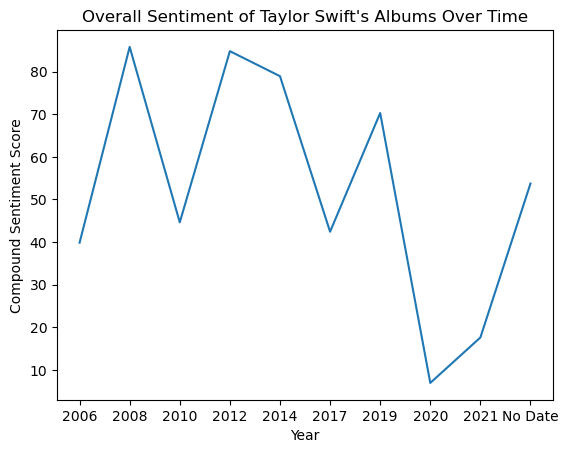

In [34]:
#Created a new DataFrame using the groupby method for album_year
yearly_sentiment = lyrics.groupby('album_year')[['pos', 'neg', 'compound']].sum().reset_index()

# Visualized sentiment over time
plt.plot(yearly_sentiment['album_year'], yearly_sentiment['compound'])
plt.title('Overall Sentiment of Taylor Swift\'s Albums Over Time')
plt.xlabel('Year')
plt.ylabel('Compound Sentiment Score')
plt.show()

#Her degree of positivity has really fluctuated over time.
#Her 2020 album was by far the least positive, though all of her albums are actually positive.

# 24. Day or Night? Positive or Negative?
### Finally the big reveal. Does Taylor Swift write more positively about day or night?

In [35]:
#Created two DataFrames: one for all the lyrics that mention night and one for all the lyrics that mention day.
#Checked that each DataFrame has the right number of values with the len() function
#Calculated the sentiment for both night and day using the compound value and printed them.

#create a DataFrame filtered for only night mentions
night = lyrics[lyrics['night']==True]

#create a DataFrame filtered for only day mentions
day = lyrics[lyrics['day']==True]

#print the length of the night and day DataFrames
print("night: ",len(night))
print("day: ",len(day))

night:  287
day:  387


# 25. Day Sentiment and Night Sentiment

In [36]:
# 22. Calculated the sentiment of each day and night DataFrame from the compound values
night_sentiment = night['compound'].sum()
day_sentiment = day['compound'].sum()

#print the results
print("night sentiment: ", night_sentiment)
print("day_sentiment: ", day_sentiment)

night sentiment:  20.1979
day_sentiment:  34.364000000000004


### She's still overall more positive in her sentiment about day than night! This shows that the lyrics referencing "day" have a higher overall sentiment score compared to those referencing "night," indicating that, on average, the sentiment toward "day" is more positive in Taylor Swift's lyrics.

# 26. Distribution of Sentiments in Lyrics

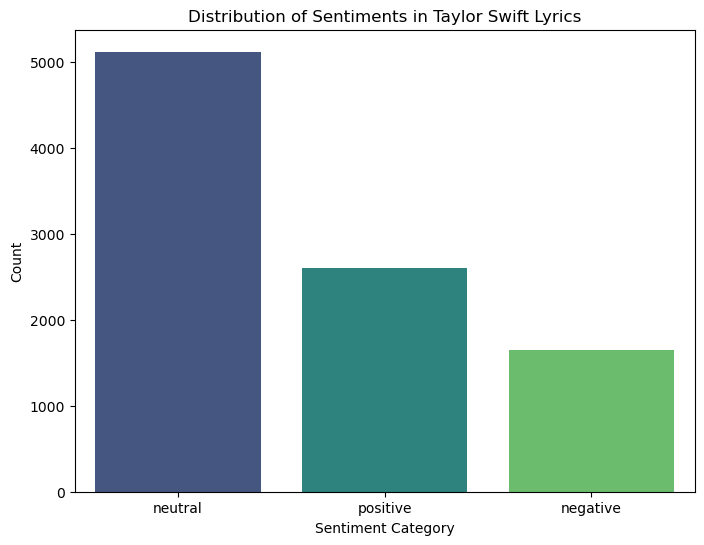

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Countplot of sentiment categories
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment_category', data=lyrics, palette='viridis')
plt.title('Distribution of Sentiments in Taylor Swift Lyrics')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

In [38]:
#Encoded the Target Variable
#Encoded the categorical sentiment labels into numeric format for modeling

# Initialize the label encoder
label_encoder = LabelEncoder()

# Fit and transform the sentiment category into numeric labels
lyrics['sentiment_numeric'] = label_encoder.fit_transform(lyrics['sentiment_category'])
#Sentiment categories (positive, negative, neutral) are converted to numeric codes for machine learning use.

# 27. Text Vectorization

In [39]:
#Convert the lyrics into a format suitable for machine learning (like TF-IDF or Count Vectorization)

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the clean lyrics
X = tfidf_vectorizer.fit_transform(lyrics['clean_lyric'])

# Target variable
y = lyrics['sentiment_numeric']

In [40]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 28. Logistic Regression Model

In [41]:
# Initialize the model
model = LogisticRegression(max_iter=1000)

# Train the model
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

              precision    recall  f1-score   support

    negative       0.86      0.52      0.65       322
     neutral       0.80      0.98      0.88      1002
    positive       0.90      0.75      0.82       550

    accuracy                           0.83      1874
   macro avg       0.85      0.75      0.78      1874
weighted avg       0.84      0.83      0.82      1874

Accuracy: 0.8329775880469584


# 29. Mean sentiment for each album

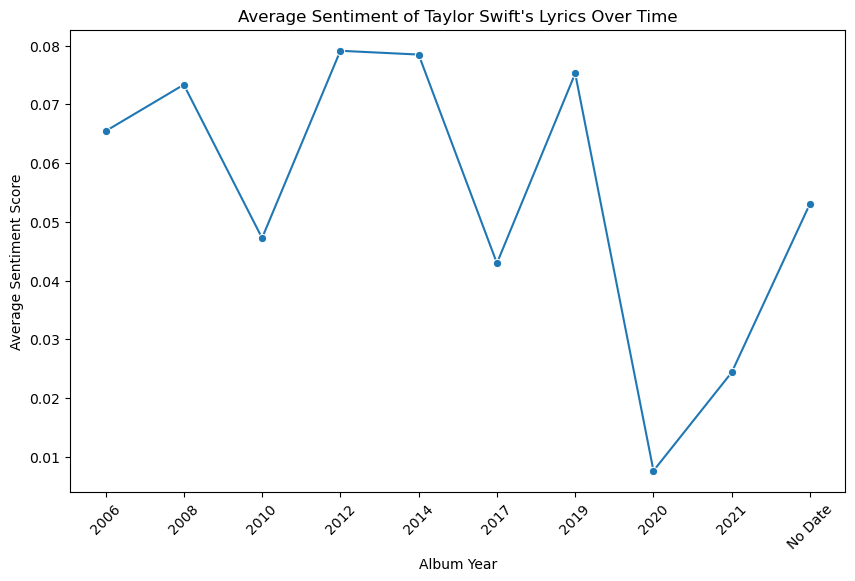

In [42]:
yearly_sentiment = lyrics.groupby('album_year')['sentiment'].mean().reset_index()

# Plot the average sentiment over the years
plt.figure(figsize=(10, 6))
sns.lineplot(x='album_year', y='sentiment', data=yearly_sentiment, marker='o')
plt.title('Average Sentiment of Taylor Swift\'s Lyrics Over Time')
plt.xlabel('Album Year')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.show()

# 30. Correlation between Album Year and Sentiment

In [43]:
# Convert 'album_year' to numeric
yearly_sentiment['album_year'] = pd.to_numeric(yearly_sentiment['album_year'], errors='coerce')

# Convert 'sentiment' to numeric
yearly_sentiment['sentiment'] = pd.to_numeric(yearly_sentiment['sentiment'], errors='coerce')

# Drop rows with NaN values
yearly_sentiment.dropna(subset=['album_year', 'sentiment'], inplace=True)

# Correlation analysis
correlation = yearly_sentiment['album_year'].corr(yearly_sentiment['sentiment'])
print(f'Correlation between album year and sentiment: {correlation}')

Correlation between album year and sentiment: -0.5682674657938919


### This indicates a moderate negative correlation between album year and sentiment. As the years progress, it suggests that the sentiment of Taylor Swift's lyrics might be becoming slightly more negative.

# 31. Correlation Matrix

In [44]:
lyrics['album_year'] = pd.to_numeric(lyrics['album_year'], errors='coerce')

lyrics_cleaned = lyrics.dropna(subset=['album_year', 'sentiment'])

print(lyrics_cleaned[['album_year', 'sentiment']].dtypes)


album_year    float64
sentiment     float64
dtype: object


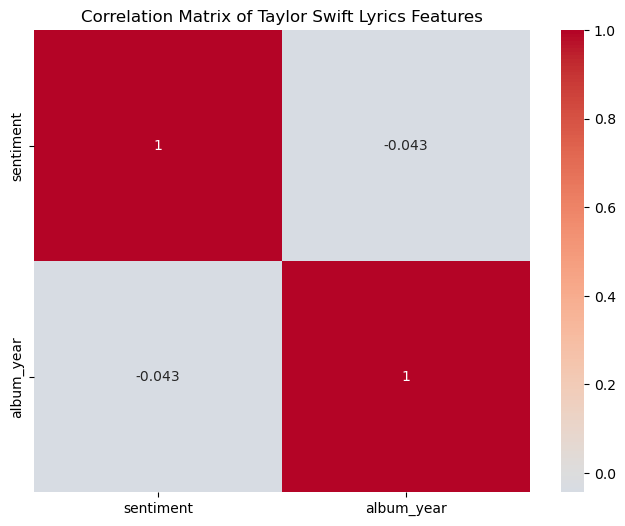

In [45]:
# Select numeric columns for correlation analysis
numeric_columns = lyrics_cleaned[['sentiment', 'album_year']]

# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Taylor Swift Lyrics Features')
plt.show()

### The -0.043 correlation between sentiment and album year suggests that there is no significant relationship between the two. Over time, Taylor Swift’s lyrics do not show a clear trend toward becoming more positive or negative, as the correlation is very close to 0.

# 32. Correlation between Sentiment and Song Length

Correlation between sentiment and song length: 0.025870491565541543


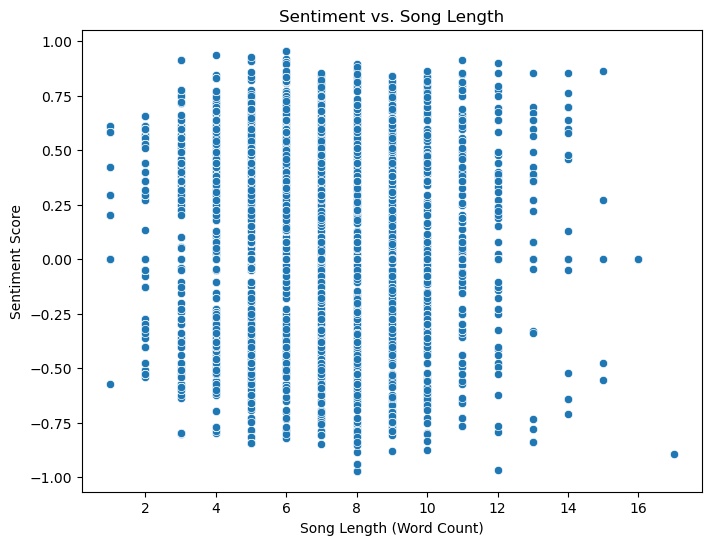

In [46]:
# Create a new column for song length (based on word count)
lyrics['song_length'] = lyrics['clean_lyric'].apply(lambda x: len(x.split()))

# Correlation analysis between sentiment and song length
correlation_song_length = lyrics['sentiment'].corr(lyrics['song_length'])
print(f'Correlation between sentiment and song length: {correlation_song_length}')

# Scatter plot for visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=lyrics['song_length'], y=lyrics['sentiment'])
plt.title('Sentiment vs. Song Length')
plt.xlabel('Song Length (Word Count)')
plt.ylabel('Sentiment Score')
plt.show()

### The correlation between sentiment and song length is 0.0259, which is very close to 0. This suggests that there is almost no correlation between the length of the song (in terms of word count) and the sentiment of the lyrics.

# 33. Correlation analysis between sentiment and vocabulary diversity

Correlation between sentiment and vocabulary diversity: -0.01582353084935939


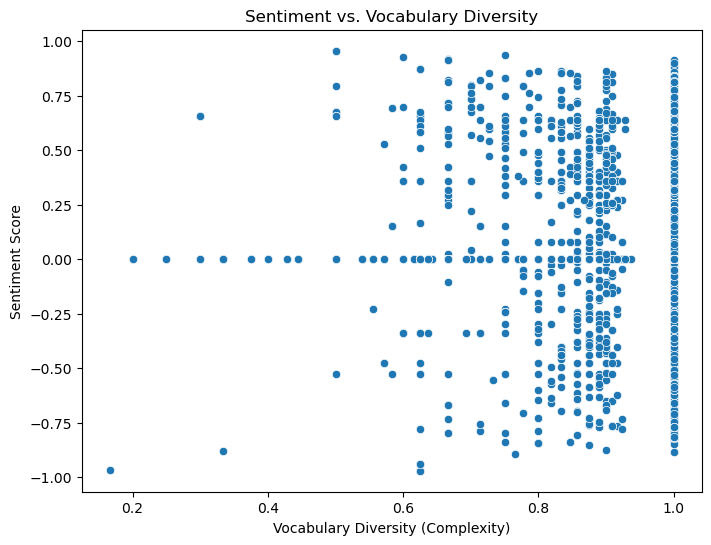

In [47]:
# Calculate vocabulary diversity (complexity)
lyrics['vocab_diversity'] = lyrics['clean_lyric'].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)

# 33. Correlation analysis between sentiment and vocabulary diversity
correlation_complexity = lyrics['sentiment'].corr(lyrics['vocab_diversity'])
print(f'Correlation between sentiment and vocabulary diversity: {correlation_complexity}')

# Scatter plot for visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=lyrics['vocab_diversity'], y=lyrics['sentiment'])
plt.title('Sentiment vs. Vocabulary Diversity')
plt.xlabel('Vocabulary Diversity (Complexity)')
plt.ylabel('Sentiment Score')
plt.show()

### This means that songs with more diverse vocabularies (higher complexity) are neither consistently more positive nor negative compared to those with less complex vocabularies.

### This following code demonstrates how to build, train, and evaluate a logistic regression model using sklearn. It covers the entire workflow from model initialization to evaluation, providing insights into how well the model performs on the given dataset.

# 34. SVM Model

In [48]:
# Initialize the SVM model
svm_model = SVC(kernel='linear')

# Train the model
svm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
print("Support Vector Machine Model Evaluation:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))
print(f'Accuracy: {accuracy_score(y_test, y_pred_svm)}')

Support Vector Machine Model Evaluation:
              precision    recall  f1-score   support

    negative       0.85      0.67      0.75       322
     neutral       0.88      0.98      0.93      1002
    positive       0.91      0.84      0.87       550

    accuracy                           0.88      1874
   macro avg       0.88      0.83      0.85      1874
weighted avg       0.88      0.88      0.88      1874

Accuracy: 0.8836712913553896


### The model is especially effective in predicting neutral and positive sentiments, but there is some room for improvement in negative sentiment recall.

# 35. Multinomial Naive Bayes Model


In [49]:
# Initialize the Multinomial Naive Bayes model
nb_model = MultinomialNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
print("Multinomial Naive Bayes:")
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
print(f'Accuracy: {accuracy_score(y_test, y_pred_nb)}')

Multinomial Naive Bayes:
              precision    recall  f1-score   support

    negative       0.89      0.30      0.45       322
     neutral       0.73      0.98      0.83      1002
    positive       0.86      0.64      0.73       550

    accuracy                           0.76      1874
   macro avg       0.82      0.64      0.67      1874
weighted avg       0.79      0.76      0.74      1874

Accuracy: 0.7641408751334045


# 36. Random Forest Model

In [50]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Model Evaluation:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))
print(f'Accuracy: {accuracy_score(y_test, y_pred_rf)}')

Random Forest Model Evaluation:
              precision    recall  f1-score   support

    negative       0.94      0.70      0.80       322
     neutral       0.89      0.98      0.93      1002
    positive       0.91      0.87      0.89       550

    accuracy                           0.90      1874
   macro avg       0.91      0.85      0.88      1874
weighted avg       0.90      0.90      0.90      1874

Accuracy: 0.9012806830309499


### Negative sentiment recall is still a bit lower, similar to the SVM model, but the overall performance is strong, especially with the high accuracy.

# In conclusion, my analysis of Taylor Swift's lyrics reveals several key insights:

### 1. Her lyrics generally express a positive sentiment, though some albums show a trend toward more negative tones over time.
### 2. The themes of 'day' and 'love' appear to be more positively charged compared to 'night' and 'hate'.
### 3. There is minimal correlation between song length, vocabulary diversity, and sentiment.
### 4. The Random Forest model performed the best in predicting sentiment, with an overall accuracy of 90.13%.


# THANK YOU!!!